## 1. Simplified Decision Tree

In [1]:
# Each item has "two" continuous features x.
# The class label is binary and encoded as y.
# Data files are in plaintext with one labeled item per line, separated by whitespace.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import sys
import re
from sklearn import tree
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial

In [3]:
def GetEntropy(data):
    freq = pd.Series(data[:,2]).value_counts()
    probs = freq / len(data)
    entropy = np.sum(-(probs * np.log2(probs)))
    return entropy

def GetConditionalEntropy_SplitInfo(data, attr_col, threshold):
    n = len(data)
    if n == 0:
        return float('inf'), float('inf')
    
    subset_left = data[data[:, attr_col] >= threshold]
    subset_right = data[data[:, attr_col] < threshold]
    
    p_left = len(subset_left) / n
    p_right = len(subset_right) / n
    
    conditional_entropy = p_left * GetEntropy(subset_left) + p_right * GetEntropy(subset_right)
    if p_left == 0 or p_right == 0:
        split_info = 0
    else:
        split_info = - (p_left * np.log2(p_left) + p_right * np.log2(p_right))    
    return conditional_entropy, split_info

def GetInformationGainRatio(data, attr_col, threshold):
    conditional_entropy, split_info = GetConditionalEntropy_SplitInfo(data, attr_col, threshold)
    info_gain = GetEntropy(data) - conditional_entropy
    if split_info == 0:
        return info_gain, -float('inf')
    else:
        return info_gain, info_gain / split_info

In [4]:
class Node:
    def __init__(self, attr = None, threshold = None, infogain = None, pred_left = None, pred_right = None, major_label = None):
        self.attr = attr
        self.threshold = threshold
        self.infogain = infogain
        self.pred_left = pred_left
        self.pred_right = pred_right
        self.left = None
        self.right = None
        self.major_label = None

def PredictClassLabel(data):
    n_class = pd.Series(data[:,2]).value_counts()
    if len(n_class) > 1 and len(np.unique(n_class)) == 1:
        return 1 # no majority class in a leaf, predict 1
    else:
        return n_class.idxmax()
    
def FindBestSplit(data):
    max_info_gain = -float('inf')
    best_attr, best_threshold = None, None

    for attr in range(2):
        possible_threshold = np.unique(data[:,attr])
        for t in possible_threshold:
            gain_ratio = GetInformationGainRatio(data, attr, t)[1]
    
            if gain_ratio > max_info_gain:
                max_info_gain = gain_ratio
                best_attr = attr
                best_threshold = t
            
    return best_attr, best_threshold, round(max_info_gain, 4)

def MakeSubtree(data, node):
    
    # Stop if the node is empty:
    if len(data) == 0: 
        return print("")

    ### Find the best split and predict the node label based on the majority label.
    best_attr, best_threshold, max_info_gain = FindBestSplit(data)    
    
    # Stop if maximum information gain ratio is 0 or
    #      if the entropy of any candidates split is zero (split information is all 0):
    if max_info_gain == 0 or max_info_gain == -float('inf'):
        node.major_label = PredictClassLabel(data)
        return print("")

    # split data
    subset_left = data[data[:,best_attr] >= best_threshold]
    subset_right = data[data[:,best_attr] < best_threshold]

    best_attr1, best_threshold1, pred_left1, pred_right1 = SplitTree(subset_left)
    best_attr2, best_threshold2, pred_left2, pred_right2 = SplitTree(subset_right)    

    if pred_left1 is not None:
        node.left = Node(attr = best_attr1, threshold = best_threshold1, 
                         pred_left = pred_left1, pred_right = pred_right1)
        MakeSubtree(subset_left, node.left)
    else:
        node.pred_left = round(best_attr1)

    if pred_right2 is not None:
        node.right = Node(attr = best_attr2, threshold = best_threshold2, 
                          pred_left = pred_left2, pred_right = pred_right2)
        MakeSubtree(subset_right, node.right)
    else:
        node.pred_right = round(best_attr2)

def SplitTree(data):

    # Stop if the node is empty:
    if len(data) == 0: 
        return None, None, None, None
        
    ### Find the best split and predict the node label based on the majority label.
    best_attr, best_threshold, max_info_gain = FindBestSplit(data)    
    
    # Stop if maximum information gain ratio is 0 or the entropy of any candidates split is zero (split information is all 0):
    if max_info_gain == 0 or max_info_gain == -float('inf'):
        return PredictClassLabel(data), None, None, None 
    
    # split
    subset_left = data[data[:,best_attr] >= best_threshold] 
    subset_right = data[data[:,best_attr] < best_threshold] 

    # predict
    pred_left = PredictClassLabel(subset_left)
    pred_right = PredictClassLabel(subset_right)

    return best_attr, best_threshold, pred_left, pred_right

def BuildDecisionTree(data):
    best_attr, best_threshold, max_info_gain = FindBestSplit(data)
    root = Node(best_attr, best_threshold, max_info_gain)
    MakeSubtree(data, root)
    return root            

def PrintDecisionTree(tree, indent=''):
    attr, threshold = tree.attr + 1, tree.threshold
    pred_left, pred_right = tree.pred_left, tree.pred_right
    left, right = tree.left, tree.right 
    max_info_gain = tree.infogain
    pred_label = tree.major_label

    if max_info_gain == 0 or max_info_gain == -float('inf'):
        print("Stop splitting! Predict:", tree.major_label)

    else:
        if left is None:
            print(indent + f"if (x{attr} >= {threshold}) return {pred_left}")
        else:
            print(indent + f"if (x{attr} >= {threshold})")
            PrintDecisionTree(left, indent + ' ')
            
        if right is None:
            print(indent + f"else return {pred_right}")
        else:
            print(indent + "else")
            PrintDecisionTree(right, indent + ' ')    

## 2-2. Question (Our algorithm is greedy)

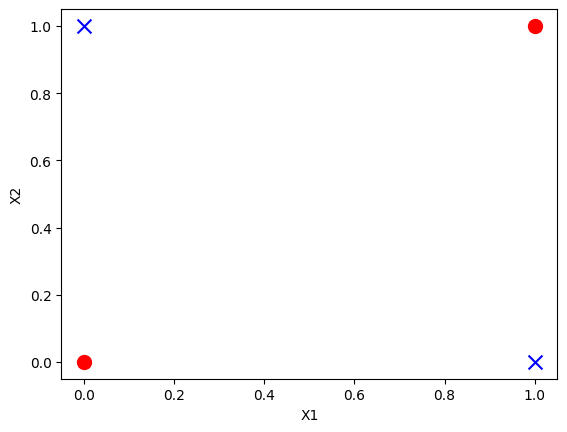

In [5]:
## Q2. (Our algorithm is greedy)
data = np.array([[0, 0, 0], [1, 1, 0], [1, 0, 1], [0, 1, 1]])

# Plot
plt.scatter(0, 0, label= 'O', color='red', marker='o', s=100)
plt.scatter(1, 1, label= 'O', color='red', marker='o', s=100)
plt.scatter(1, 0, label= 'X', color='blue', marker='x', s=100)
plt.scatter(0, 1, label= 'X', color='blue', marker='x', s=100)

plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [6]:
# Satisfy stopping criteria:
data = np.array([[0, 0, 0], [1, 1, 0], [1, 0, 1], [0, 1, 1]])
print("Info_gain_ratio with X1>=0:", GetInformationGainRatio(data, 0, 0)[1], "\n",
      "Info_gain_ratio with X1>=1:", GetInformationGainRatio(data, 0, 1)[1], "\n",
      "Info_gain_ratio with X2>=0:", GetInformationGainRatio(data, 1, 0)[1], "\n",
      "Info_gain_ratio with X2>=1:", GetInformationGainRatio(data, 1, 1)[1])

decision_tree = BuildDecisionTree(data)
PrintDecisionTree(decision_tree)

Info_gain_ratio with X1>=0: -inf 
 Info_gain_ratio with X1>=1: 0.0 
 Info_gain_ratio with X2>=0: -inf 
 Info_gain_ratio with X2>=1: 0.0

Stop splitting! Predict: 1


## 2-3. Question (Information gain ratio exercise)

In [7]:
data = np.loadtxt("Homework 2 data/Druns.txt", delimiter = " ")

cand_split, info_gain, info_gain_ratio = [], [], []
for attr in range(2):
    possible_threshold = np.unique(data[:,attr])
    cand_split.append(possible_threshold)
    for t in possible_threshold:
        temp = GetInformationGainRatio(data, attr, t)
        info_gain.append(temp[0])
        info_gain_ratio.append(temp[1])

var_list = ["X1"] * len(cand_split[0]) + ["X2"] * len(cand_split[1])
split_list = np.concatenate((cand_split[0], cand_split[1]))
info_gain_list = []
for i in range(len(info_gain_ratio)):
    if info_gain_ratio[i] == -float('inf'):
        info_gain_list.append(info_gain[i])
    else:
        info_gain_list.append(info_gain_ratio[i])

result_q2_3 = pd.DataFrame({'Variable': var_list, 'Candidate_split': split_list, 'Info_gain_ratio': np.round(info_gain_list, 4)})

In [8]:
result_q2_3

,Variable,Candidate_split,Info_gain_ratio
0,X1,0.0,0.0000
1,X1,0.1,0.1005
2,X2,-2.0,0.0000
3,X2,-1.0,0.1005
4,X2,0.0,0.0560
5,X2,1.0,0.0058
6,X2,2.0,0.0011
7,X2,3.0,0.0164
8,X2,4.0,0.0497
9,X2,5.0,0.1112


## 2-4. Question (The king of interpretability) 

In [9]:
data = np.loadtxt("Homework 2 data/D3leaves.txt", delimiter = " ")
print(data)
decision_tree = BuildDecisionTree(data)

[[10.  1.  1.]
 [10.  2.  1.]
 [10.  3.  1.]
 [ 1.  1.  0.]
 [ 1.  3.  1.]]


In [10]:
PrintDecisionTree(decision_tree)

if (x1 >= 10.0) return 1
else
 if (x2 >= 3.0) return 1
 else return 0


## 2-5. Question (Or is it?)

In [11]:
data = np.loadtxt("Homework 2 data/D1.txt", delimiter = " ")
data

array([[0.264185, 0.178456, 0.      ],
       [0.409499, 0.213456, 1.      ],
       [0.926224, 0.540329, 1.      ],
       ...,
       [0.285166, 0.956678, 1.      ],
       [0.751571, 0.514041, 1.      ],
       [0.142654, 0.226182, 1.      ]])

In [12]:
decision_tree = BuildDecisionTree(data)
PrintDecisionTree(decision_tree)

if (x2 >= 0.201829) return 1
else return 0


In [13]:
data = np.loadtxt("Homework 2 data/D2.txt", delimiter = " ")
data

array([[0.315561, 0.956006, 1.      ],
       [0.344972, 0.693422, 1.      ],
       [0.398419, 0.974354, 1.      ],
       ...,
       [0.384576, 0.609262, 0.      ],
       [0.843186, 0.848278, 1.      ],
       [0.691812, 0.751075, 1.      ]])

In [14]:
decision_tree = BuildDecisionTree(data)
PrintDecisionTree(decision_tree)

if (x1 >= 0.533076)
 if (x2 >= 0.228007)
  if (x2 >= 0.424906) return 1
  else
   if (x1 >= 0.708127) return 1
   else
    if (x2 >= 0.32625)
     if (x1 >= 0.595471)
      if (x1 >= 0.646007) return 1
      else
       if (x2 >= 0.403494) return 1
       else return 0
     else return 0
    else return 0
 else
  if (x1 >= 0.887224)
   if (x2 >= 0.037708)
    if (x2 >= 0.082895) return 1
    else
     if (x1 >= 0.960783) return 1
     else return 0
   else return 0
  else
   if (x1 >= 0.850316)
    if (x2 >= 0.169053) return 1
    else return 0
   else return 0
else
 if (x2 >= 0.88635)
  if (x1 >= 0.041245)
   if (x1 >= 0.104043) return 1
   else
    if (x1 >= 0.07642) return 0
    else return 1
  else return 0
 else
  if (x2 >= 0.691474)
   if (x1 >= 0.254049) return 1
   else
    if (x1 >= 0.191915)
     if (x2 >= 0.792752) return 1
     else return 0
    else
     if (x2 >= 0.864128)
      if (x1 >= 0.144781) return 1
      else return 0
     else return 0
  else
   if (x2 >= 0.5349

## 2-6. Question (Hypothesis space)

In [15]:
# get decision boundary
result = StringIO()
sys.stdout = result
PrintDecisionTree(decision_tree)
result_string = result.getvalue()
temp = re.findall(r'>=\s*(-?\d+\.\d+)', result_string)
getAttr = re.findall(r'if\s*\((\w+)\s*>=', result_string)
getNumbers = [float(num) for num in temp]

def draw_subplot(ax, X, Y, labels, getAttr, getNumbers, title, alpha = 0.1):
    ax.scatter(X[labels == 0], Y[labels == 0], c='red', s=100, label='Label 0', edgecolors='none', alpha=alpha)
    ax.scatter(X[labels == 1], Y[labels == 1], c='blue', s=100, label='Label 1', edgecolors='none', alpha=alpha)
    ax.set(xlabel='X1', ylabel='X2')
    ax.set_title(title)

    for attribute, num in zip(getAttr, getNumbers):
        if attribute == 'x2':
            ax.axhline(y=num, color='black', linestyle='--', linewidth=3)
        elif attribute == 'x1':
            ax.axvline(x=num, color='black', linestyle='--', linewidth=3)


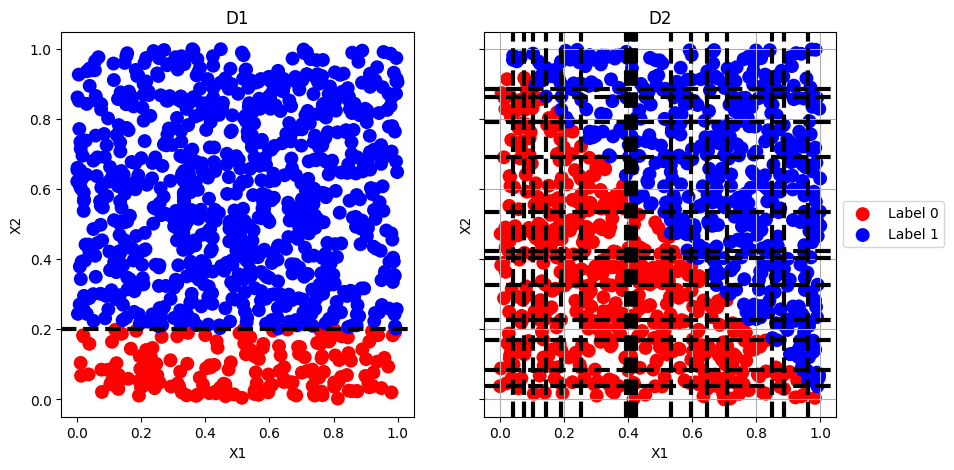

In [16]:
data = np.loadtxt("Homework 2 data/D1.txt", delimiter = " ")
X = data[:, 0]
Y = data[:, 1]
labels = data[:, 2]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10, 5))
ax1.scatter(X[labels == 0], Y[labels == 0], c='red', s=100, label='Label 0', edgecolors='none')
ax1.scatter(X[labels == 1], Y[labels == 1], c='blue', s=100, label='Label 1', edgecolors='none')
ax1.axhline(y = 0.201829, color='black', linestyle='--', linewidth = 3)
ax1.set(xlabel = 'X1', ylabel = 'X2')
ax1.set_title("D1")

data = np.loadtxt("Homework 2 data/D2.txt", delimiter = " ")
X = data[:, 0]
Y = data[:, 1]
labels = data[:, 2]
draw_subplot(ax2, X, Y, labels, getAttr, getNumbers, title = "D2", alpha = 1)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

## 2-7. Question (Learning curve)

In [17]:
data = np.loadtxt("Homework 2 data/Dbig.txt", delimiter = " ")
data

array([[-1.499372,  0.976384,  1.      ],
       [-1.499224, -0.517983,  1.      ],
       [-1.49888 , -1.271624,  1.      ],
       ...,
       [ 1.499284,  0.447541,  1.      ],
       [ 1.499313,  1.092598,  1.      ],
       [ 1.499767,  0.661564,  1.      ]])

In [18]:
n_train = 8192
indices = np.array([True] * n_train + [False] * (len(data) - n_train))

np.random.seed(1)
np.random.shuffle(data)
np.random.shuffle(indices)

train_data = data[indices == True]
test_data = data[indices == False]

D32 = train_data[0:32,]
D128 = train_data[0:128,]
D512 = train_data[0:512,]
D2048 = train_data[0:2048,]
D8192 = train_data

In [19]:
def PredictDecisionTree(tree, new_data):
    attr, threshold = tree.attr, tree.threshold
    pred_left, pred_right = tree.pred_left, tree.pred_right
    left, right = tree.left, tree.right 
    
    if new_data[attr] >= threshold:
        if left is None:
            return int(pred_left)
        else:
            return PredictDecisionTree(left, new_data)
    
    else:
        if right is None:
            return int(pred_right)
        else:
            return PredictDecisionTree(right, new_data)

In [20]:
n_train = [32, 128, 512, 2048, 8192]
decision_trees = {}
for size in n_train:
    decision_trees[size] = BuildDecisionTree(locals()[f'D{size}'])

pred_labels = [[] for i in range(len(n_train))]
errors = [0] * len(n_train)
for j, size in enumerate(n_train):
    for i in range(len(test_data)):
        pred_labels[j].append(PredictDecisionTree(decision_trees[size], test_data[i,:]))
    errors[j] = 1 - np.mean(np.array(pred_labels[j] == test_data[:,2]))

In [21]:
# count the number of node and get decision boundary

n_nodes = [0] * len(n_train)
getAttr = [[] for i in range(len(n_train))]
getNumbers = [[] for i in range(len(n_train))]

for i in range(len(n_train)):
    result = StringIO()
    sys.stdout = result
    PrintDecisionTree(decision_trees[n_train[i]])
    result_string = result.getvalue()
    temp = re.findall(r'>=\s*(-?\d+\.\d+)', result_string)
    getAttr[i] = re.findall(r'if\s*\((\w+)\s*>=', result_string)
    n_nodes[i] = result_string.count("return")
    getNumbers[i] = [float(num) for num in temp]

In [22]:
result_q2_7 = pd.DataFrame({'N': n_train, 'no_Nodes': n_nodes, 'Test_Error': np.round(errors, 4)})
result_q2_7

,N,no_Nodes,Test_Error
0,32,9,0.1355
1,128,16,0.1261
2,512,28,0.0470
3,2048,66,0.0354
4,8192,117,0.0188


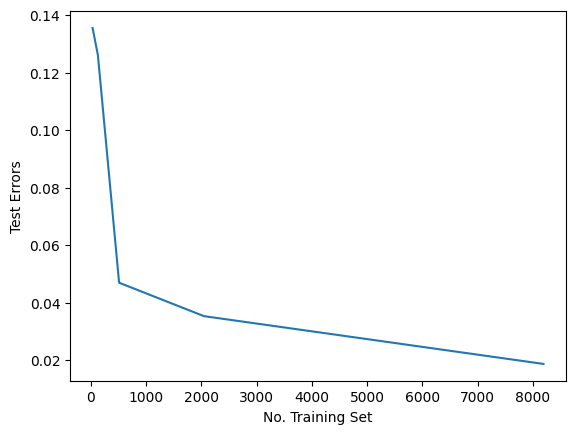

In [23]:
plt.plot(n_train, errors)
plt.xlabel('No. Training Set')
plt.ylabel('Test Errors')
plt.show()

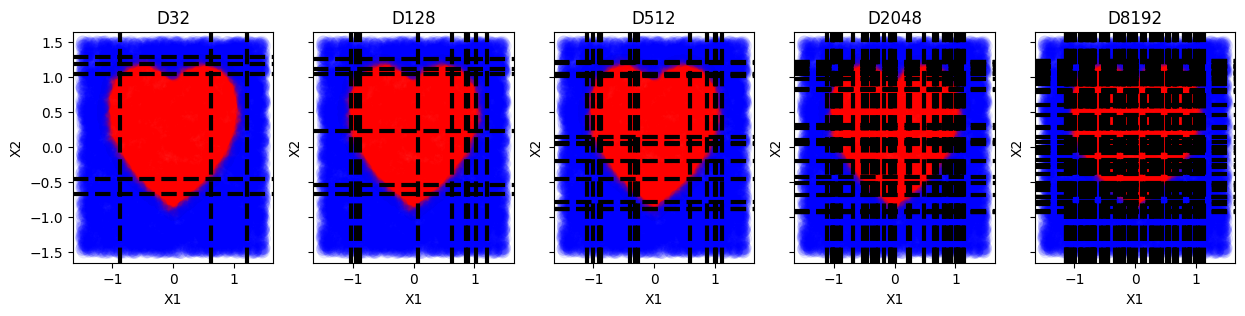

In [24]:
X, Y, labels = data[:, 0], data[:, 1], data[:, 2]
titles = ["D32", "D128", "D512", "D2048", "D8192"]

fig, axes = plt.subplots(1, 5, sharey=True, figsize=(15, 3))
for i, ax in enumerate(axes):
    draw_subplot(ax, X, Y, labels, getAttr[i], getNumbers[i], titles[i])

plt.show()

## 3. sklearn

In [25]:
def BuiltinDecisionTree(train_data, test_data):
    X, y = train_data[:,0:2], train_data[:,2]
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X, y)
    pred_labels = clf.predict(test_data[:,0:2])
    error = 1 - np.mean(pred_labels == test_data[:,2])
    n_nodes = clf.tree_.node_count
    return n_nodes, error

n_nodes2, errors2 = [0] * len(n_train), [0] * len(n_train)
n_nodes2[0], errors2[0] = BuiltinDecisionTree(D32, test_data)
n_nodes2[1], errors2[1] = BuiltinDecisionTree(D128, test_data)
n_nodes2[2], errors2[2] = BuiltinDecisionTree(D512, test_data)
n_nodes2[3], errors2[3] = BuiltinDecisionTree(D2048, test_data)
n_nodes2[4], errors2[4] = BuiltinDecisionTree(D8192, test_data)

In [26]:
result_q3 = pd.DataFrame({'N': n_train, 'no_Nodes': n_nodes2, 'Test_Error': np.round(errors2, 4)})
result_q3

,N,no_Nodes,Test_Error
0,32,17,0.1250
1,128,29,0.0796
2,512,53,0.0531
3,2048,115,0.0282
4,8192,239,0.0127


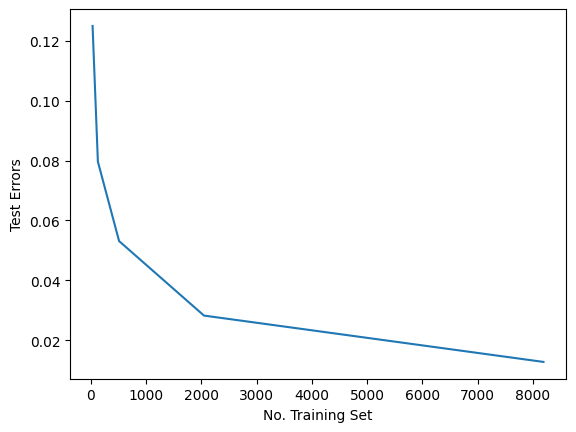

In [27]:
plt.plot(n_train, errors2)
plt.xlabel('No. Training Set')
plt.ylabel('Test Errors')
plt.show()

## 4. Lagrange Interpolation

In [29]:
np.random.seed(2)

a, b = -2 * np.pi, 2 * np.pi
n = 100
x_train = np.random.uniform(low = a, high = b, size = n)
y_train = np.sin(x_train)
x_test = np.random.uniform(low = a, high = b, size = n)
y_test = np.sin(x_test)
f = lagrange(x_train, y_train)
train_mse = [np.log(np.mean((y_train - f(x_train))**2))]
test_mse = [np.log(np.mean((y_test - f(x_test))**2))]

In [30]:
std_list = [1, 2, 3]
for std in std_list:
    x_train, y_train = np.random.uniform(low = a, high = b, size = n) + np.random.normal(0, std, n), np.sin(x_train) 
    x_test, y_test = np.random.uniform(low = a, high = b, size = n) + np.random.normal(0, std, n), np.sin(x_test) 
    train_mse.append(np.log(np.mean((y_train - f(x_train))**2)))
    test_mse.append(np.log(np.mean((y_test - f(x_test))**2)))

In [31]:
std_list = [0] + std_list
results_4 = pd.DataFrame({'std': std_list, 'log(train_mse)': np.round(train_mse, 4), 'log(test_mse)': np.round(test_mse, 4)})
results_4

,std,log(train_mse),log(test_mse)
0,0,193.5559,193.9326
1,1,218.9489,238.5217
2,2,253.0015,285.9245
3,3,276.5057,312.6823
